Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: GPU


Device set to use cuda:0



=== Classification Report (Test) ===
                  precision    recall  f1-score   support

Hallucinated (0)       0.77      0.74      0.76       348
     Factual (1)       0.75      0.78      0.77       348

        accuracy                           0.76       696
       macro avg       0.76      0.76      0.76       696
    weighted avg       0.76      0.76      0.76       696

Confusion matrix:
 [[259  89]
 [ 76 272]]
ROC-AUC: 0.8707309420002642


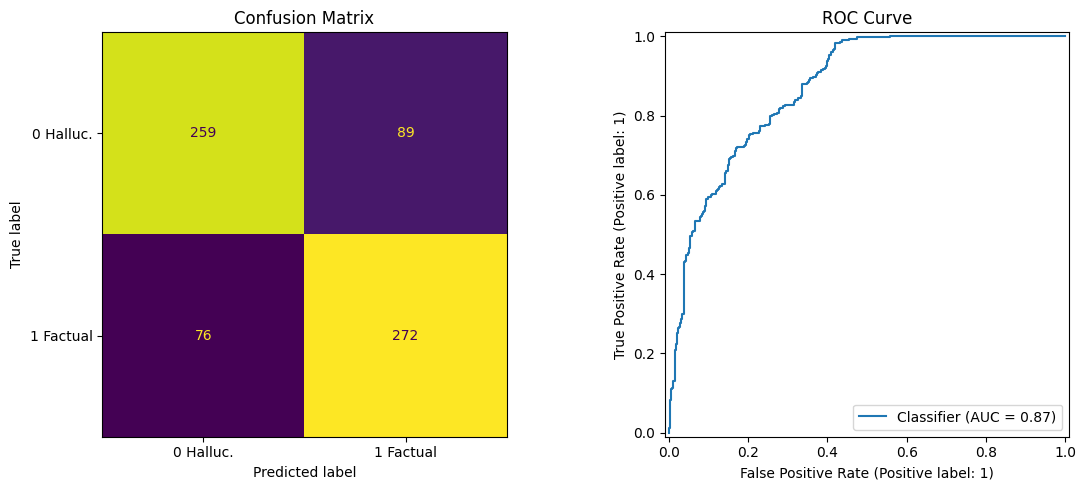


Single-example predictions:
{'label': 'FACTUAL', 'score': 0.5240384936332703, 'pred_int': 1}
{'label': 'FACTUAL', 'score': 0.854205310344696, 'pred_int': 1}

Best threshold for F1 on this test set: 0.12 (F1=0.815)


In [1]:
# =========================================
# Colab: Evaluate Hallucination Prediction Model (HPM)
# =========================================
!pip install -q transformers datasets scikit-learn

from pathlib import Path
import json, numpy as np, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, pipeline

# -------------------------
# CONFIG — update these paths if needed
# -------------------------
BEST_DIR  = "/content/drive/MyDrive/Colab Notebooks/NewBestModel/hallucination_detector_final"  # saved best model
TEST_JSON = "/content/drive/MyDrive/Colab Notebooks/test_dataset.json"  # test split JSON

# -------------------------
# 0) Mount Drive (needed if files live in Drive)
# -------------------------
from google.colab import drive
drive.mount('/content/drive')

# -------------------------
# 1) Load model & tokenizer
# -------------------------
device_id = 0 if torch.cuda.is_available() else -1  # use GPU if available
print("Using device:", "GPU" if device_id==0 else "CPU")

model = DistilBertForSequenceClassification.from_pretrained(BEST_DIR)
tokenizer = DistilBertTokenizerFast.from_pretrained(BEST_DIR)

clf = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device_id)

# -------------------------
# 2) Load test set
# Expect columns: question, answer, evidence (optional), and label/labels (0/1)
# -------------------------
df = pd.read_json(TEST_JSON)
# normalize schema
df["question"] = df["question"].astype(str)
df["answer"]   = df["answer"].astype(str)
df["evidence"] = df.get("evidence", "").fillna("").astype(str)

if "label" in df.columns:
    df["y_true"] = df["label"].astype(int)
elif "labels" in df.columns:
    df["y_true"] = df["labels"].astype(int)
else:
    raise ValueError("Test file must include 'label' or 'labels' field with 0/1 values.")

# Build left text (use evidence when present)
left_texts  = [f"Q: {q}  EVIDENCE: {e}" if e.strip() else q for q, e in zip(df["question"], df["evidence"])]
right_texts = df["answer"].tolist()

pairs = [{"text": lt, "text_pair": rt} for lt, rt in zip(left_texts, right_texts)]

# -------------------------
# 3) Batch predictions
# -------------------------
preds = clf(pairs, batch_size=32, truncation=True)

# Map pipeline labels to ints robustly
label_map = {"FACTUAL":1, "HALLUCINATED":0, "factual":1, "hallucinated":0, "LABEL_1":1, "LABEL_0":0}
y_pred = np.array([label_map.get(p["label"], 1 if "1" in p["label"] else 0) for p in preds], dtype=int)

# Positive class probabilities for ROC/AUC
probs_1 = np.array([
    p["score"] if label_map.get(p["label"], 1 if "1" in p["label"] else 0)==1 else 1.0 - p["score"]
    for p in preds
])

# -------------------------
# 4) Metrics
# -------------------------
print("\n=== Classification Report (Test) ===")
print(classification_report(df["y_true"].values, y_pred, target_names=["Hallucinated (0)","Factual (1)"]))

print("Confusion matrix:\n", confusion_matrix(df["y_true"].values, y_pred))

try:
    print("ROC-AUC:", roc_auc_score(df["y_true"].values, probs_1))
except ValueError:
    print("ROC-AUC: undefined (test set may contain a single class only)")

# -------------------------
# 5) Plots: Confusion Matrix + ROC
# -------------------------
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

fig, ax = plt.subplots(1,2, figsize=(12,5))
ConfusionMatrixDisplay.from_predictions(df["y_true"].values, y_pred,
                                        display_labels=["0 Halluc.","1 Factual"], ax=ax[0], colorbar=False)
ax[0].set_title("Confusion Matrix")

# ROC curve (skip if AUC undefined)
try:
    RocCurveDisplay.from_predictions(df["y_true"].values, probs_1, ax=ax[1])
    ax[1].set_title("ROC Curve")
except Exception as e:
    ax[1].set_visible(False)
plt.tight_layout()
plt.show()

# -------------------------
# 6) Quick single-example helper
# -------------------------
def predict_pair(question: str, answer: str, evidence: str = ""):
    left = f"Q: {question}  EVIDENCE: {evidence}" if evidence else question
    out = clf({"text": left, "text_pair": answer})
    out = out[0] if isinstance(out, list) else out
    label = out["label"]
    score = float(out["score"])
    pred_int = label_map.get(label, 1 if "1" in label else 0)
    return {"label": label, "score": score, "pred_int": pred_int}

# Examples
print("\nSingle-example predictions:")
print(predict_pair("David Thewlis was born in 1983.", "David Thewlis was born in 1983.", "David_Thewlis"))
print(predict_pair("The moon is the center of the solar system.", "The moon is the center of the solar system.", "Solar_System"))

# -------------------------
# 7) Optional: threshold tuning (optimize F1)
# -------------------------
def tune_threshold(y_true, probs, metric="f1", grid=None):
    from sklearn.metrics import f1_score, precision_score, recall_score
    if grid is None:
        grid = np.linspace(0.1, 0.9, 33)
    best_t, best = 0.5, -1
    for t in grid:
        yp = (probs >= t).astype(int)
        if metric == "f1":
            m = f1_score(y_true, yp)
        elif metric == "precision":
            m = precision_score(y_true, yp, zero_division=0)
        else:
            m = recall_score(y_true, yp, zero_division=0)
        if m > best:
            best, best_t = m, t
    return best_t, best

best_t, best_f1 = tune_threshold(df["y_true"].values, probs_1, metric="f1")
print(f"\nBest threshold for F1 on this test set: {best_t:.2f} (F1={best_f1:.3f})")
